# Import modules

In [1]:
import numpy as np
import pandas as pd
import datetime as datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from tqdm import tqdm

## Convert time: timestamp and registration date to unix timestamp

In [2]:
# Read the split dataset
# Available on github/data/splits
df_train = pd.read_csv('bpi2017_train.csv')
df_test = pd.read_csv('bpi2017_test.csv')
df_val = pd.read_csv('bpi2017_val.csv')

# Perform conversion
df_train['Date'] = np.array(df_train['time:timestamp'].values, dtype = 'datetime64').astype(datetime.datetime)
df_train['time:unix'] = (df_train['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df_test['Date'] = np.array(df_test['time:timestamp'].values, dtype = 'datetime64').astype(datetime.datetime)
df_test['time:unix'] = (df_test['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df_val['Date'] = np.array(df_val['time:timestamp'].values, dtype = 'datetime64').astype(datetime.datetime)
df_val['time:unix'] = (df_val['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if sys.path[0] == '':


In [3]:
# Define mapping 
mapping_train = {item:i for i, item in enumerate(df_train["lifecycle:transition"].unique())}
mapping_test = {item:i for i, item in enumerate(df_test["lifecycle:transition"].unique())}
mapping_val = {item:i for i, item in enumerate(df_val["lifecycle:transition"].unique())}

# Apply mapping
df_train["transition"] = df_train["lifecycle:transition"].apply(lambda x: mapping_train[x])
df_test["transition"] = df_test["lifecycle:transition"].apply(lambda x: mapping_test[x])
df_val["transition"] = df_val["lifecycle:transition"].apply(lambda x: mapping_val[x])

In [4]:
def Forest(n):
    df_1 = df_train.copy()
    df_2 = df_val.copy()
    # Define predictors
    predictors = ['time:unix', 'transition']
    # Define the classifier
    rfc = RandomForestClassifier(n_estimators = n)
    # Fit the model
    rfc.fit(df_1[predictors], df_1['concept:name'])
    pred_val = rfc.predict(df_2[predictors])
    df_2['predicted_action'] = pred_val
    #
    actions_taken = df_2['concept:name']
    actions_taken = actions_taken[1: ]
    #
    actions_pred = df_2['predicted_action']
    actions_pred = actions_pred[: -1]
    #
    test = pd.concat([actions_taken, actions_pred], axis=1)
    test.dropna(axis=0, inplace=True)
    #
    return metrics.accuracy_score(test['concept:name'], test['predicted_action'])

In [5]:
n_lst = [10 * (i + 1) for i in range(20)]
accuracy_lst = [Forest(i) for i in tqdm(n_lst)]
accuracy_lst

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:11:05<00:00, 213.29s/it]


[0.21457292242077,
 0.21720642832367715,
 0.2152023945634161,
 0.21624295055432088,
 0.21644206929332116,
 0.2166733039579667,
 0.2164741852189664,
 0.21666688077283763,
 0.21711650373187055,
 0.21678892129028943,
 0.2173091992857418,
 0.216724689438999,
 0.21745693254370976,
 0.21700730958467684,
 0.21689811543748314,
 0.2169559241036445,
 0.21762393535706487,
 0.21707154143596727,
 0.217951517798646,
 0.21785517002171037]

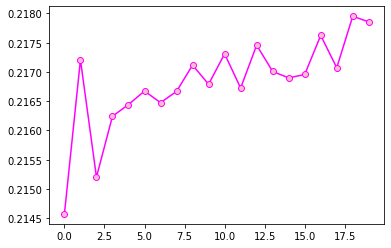

In [9]:
import matplotlib.pyplot as plt
plt.plot(accuracy_lst, color='magenta', marker='o',mfc='pink' ) #plot the data
#plt.xticks(n_lst) #set the tick frequency on x-axis